In [3]:
import json
import os
import argparse
import pathlib
import pandas as pd
from glob import glob
import rouge
import nltk
import matplotlib.pyplot as plt
from scipy import stats

presumm_threshold = 0.2


def get_chapter_data(line):
    chapter = json.loads(line)
    return {
        'book_id': chapter['book_id'].replace(" ", "_").lower(),
        'source': chapter['source']
    }


def sort_by_score(x):
    return x["prediction"]


def get_text_and_scores(result_path):
    df = pd.read_csv(result_path, sep='\t', engine='python')
    text = df["text"].astype(str)
    predictions = df["score"].astype(float)
    assert len(predictions) == len(text)
    # print(predictions)
    # print(text)
    return {"predictions": list(predictions), "text": list(text), "filename": result_path}


def get_human_summary(summary_path):
    with open("../../booksum/scripts/" + summary_path, encoding='utf-8') as f:
        summary_json = json.load(f)
        return summary_json["summary"]


def generate_concat_summary(related_files, k):
    cat_related_files = []
    for related_file in related_files:
        cat_related_files.extend([{"prediction": related_file["predictions"][idx],
                                   "text": related_file["text"][idx]} for idx in range(len(related_file["predictions"]))])
    cat_related_files.sort(key=sort_by_score, reverse=True)
    return cat_related_files[:((k+1)*len(related_files))]


def generate_each_summary(related_files, k):
    generated_summary = []
    related_files_list = []
    for related_file in related_files:
        related_files_list.append([{"prediction": related_file["predictions"][idx],
                                    "text": related_file["text"][idx]} for idx in range(len(related_file["predictions"]))])
    for related_file in related_files_list:
        related_file.sort(key=sort_by_score, reverse=True)
        generated_summary.extend(related_file[:(k+1)])
    return generated_summary


def generate_threshold_summary(related_files, k):
    global presumm_threshold
    generated_summary = []
    for related_file in related_files:
        generated_summary.extend([{"prediction": related_file["predictions"][idx],
                                   "text": related_file["text"][idx]} for idx in range(len(related_file["predictions"]))
                                  if related_file["predictions"][idx] > presumm_threshold])
    return generated_summary


def calculate_F1():
    chapters_test_split = open(pathlib.Path("../../booksum/alignments/chapter-level-summary-alignments/chapter_summary_aligned_all_split.jsonl"),
                               encoding='utf-8')
    chapters_data = [get_chapter_data(line) for line in chapters_test_split]
    max_k = 10
    used_files = []
    results = {
        "each": {
            "data": [],  # Shape: [k, f1_score, summary_path]
            "means": [],  # Shape: float

        },
        "concat": {
            "data": [],  # Shape: [k, f1_score, summary_path]
            "means": [],  # Shape: float

        },
        "threshold": {
            "data": [],  # Shape: [k, f1_score, summary_path]
            "means": [],  # Shape: float

        },
        "p_value": [],  # Shape: float
    }
    modes = ["each", "concat", "threshold"]
    threshold_f1_scores = []

    book_data = []
    f = open(pathlib.Path("../../booksum/alignments/book-level-summary-alignments/book_summaries_aligned_all.jsonl"),
             encoding='utf-8')
    for line in f:
        content = json.loads(line)
        summary_path = content['summary_path']
        book_title = content['title']
        source = content['source']
        # Format title.
        book_title = book_title.replace(':', "").replace(" ", "_").lower()

        chapters = [x for x in chapters_data if x['book_id'].split(
            '.')[0] == book_title and x['source'] == source]
        paths = [pathlib.Path("../../PreSumm/results/booksum_summaries/20000/").joinpath(
            "ext_bertbooksum_summaries." + chapter['book_id'].strip() + "." + chapter['source'].strip() + '.tsv') for chapter in chapters]
        related_files = []
        for path in paths:
            try:
                related_files.append(get_text_and_scores(path))
            except:
                # print("Could not open {}.".format(path))
                pass

        book_data.append({
            "data": related_files,
            "summary_path": summary_path,
            "book_title": book_title,
            "source": source})
        used_files.extend(related_files)
    f.close()

    for k in range(max_k):

        for mode in modes:

            curr_data_list = []

            book_count = 0

            for book in book_data:
                summary_path = book['summary_path']
                book_title = book['book_title']
                source = book['source']

                try:
                    human_summary = get_human_summary(summary_path)
                    # print("Summary Length : {}".format(len(human_summary)))
                except:
                    human_summary = None
                    print("Could not find summary.")

                current_book_files = book['data']

                if len(chapters) == 0:
                    print("No files found.")
                    continue

                elif (human_summary is None):
                    print("Files exist but no summary.")
                    print(summary_path)

                if mode == "concat":
                    generated_summary_sents = generate_concat_summary(
                        current_book_files, k)
                elif mode == "each":
                    generated_summary_sents = generate_each_summary(
                        current_book_files, k)
                elif mode == "threshold":
                    if k == 0:
                        generated_summary_sents = generate_threshold_summary(
                            current_book_files, k)
                    else:
                        curr_data_list.append(
                            [k, threshold_f1_scores[book_count], summary_path])
                        book_count += 1
                        continue
                else:
                    print("Invalid mode '{}'".format(mode))
                    return False

                # Concat summary sentences into one string.
                generated_summary = ""
                for sentence in generated_summary_sents:
                    generated_summary = generated_summary + \
                        " " + sentence["text"]

                # Removes first " "
                generated_summary = generated_summary[1:]

                evaluator = rouge.Rouge(metrics=['rouge-n'],
                                        max_n=1,
                                        limit_length=False)
                scores = evaluator.get_scores(
                    generated_summary, human_summary)

                if mode == "threshold":
                    threshold_f1_scores.append(scores['rouge-1']['f'])

                # print(scores['rouge-1'])
                curr_data_list.append(
                    [k, scores['rouge-1']['f'], summary_path])
                book_count += 1

            results[mode]["data"].append(curr_data_list)

            ROUGE_list = [curr_data_item[1]
                          for curr_data_item in curr_data_list]
            ROUGE_mean = sum(ROUGE_list) / len(ROUGE_list)
            results[mode]["means"].append(ROUGE_mean)

            print("Mode: {}".format(mode))
            print("Books covered: {}".format(book_count))
            print("k: {}".format(k+1))
            print("Mean ROUGE-1 F1: {}".format(ROUGE_mean))
            print()

        each = [result_item[1]
                for result_item in results["each"]["data"][k]]
        concat = [result_item[1]
                  for result_item in results["concat"]["data"][k]]
        paired_t_test = stats.ttest_rel(each, concat)
        results["p_value"].append(paired_t_test.pvalue)
        print("P Value: {} < 0.05 = {}".format(
            paired_t_test.pvalue, str(paired_t_test.pvalue < 0.05)))
        print()

    # Create graph.
    return results


In [4]:
input_path_list = glob(os.path.normpath("../../PreSumm/results/booksum_summaries/20000/") + "/*")
print("Evaluation results from {} files".format(len(input_path_list)))

results = calculate_F1()

Evaluation results from 11316 files
Mode: each
Books covered: 405
k: 1
Mean ROUGE-1 F1: 0.35495023041034995

Mode: concat
Books covered: 405
k: 1
Mean ROUGE-1 F1: 0.35001997756804076

Mode: threshold
Books covered: 405
k: 1
Mean ROUGE-1 F1: 0.41512936419128477

P Value: 1.6100588346837353e-05 < 0.05 = True

Mode: each
Books covered: 405
k: 2
Mean ROUGE-1 F1: 0.4266235872976509

Mode: concat
Books covered: 405
k: 2
Mean ROUGE-1 F1: 0.42576983261972706

Mode: threshold
Books covered: 405
k: 2
Mean ROUGE-1 F1: 0.41512936419128477

P Value: 0.23669779092118445 < 0.05 = False

Mode: each
Books covered: 405
k: 3
Mean ROUGE-1 F1: 0.44141921119815036

Mode: concat
Books covered: 405
k: 3
Mean ROUGE-1 F1: 0.4411134929848623

Mode: threshold
Books covered: 405
k: 3
Mean ROUGE-1 F1: 0.41512936419128477

P Value: 0.5892122527938042 < 0.05 = False

Mode: each
Books covered: 405
k: 4
Mean ROUGE-1 F1: 0.43872554621965526

Mode: concat
Books covered: 405
k: 4
Mean ROUGE-1 F1: 0.4378577135613733

Mode:

KeyboardInterrupt: 

In [ ]:
# Comment these out to avoid saving the csv files.
modes = ["each", "concat", "threshold"]
for mode in modes:
    flattened_results = [
        item for sublist in results[mode]["data"] for item in sublist]
    df = pd.DataFrame(flattened_results, columns=[
        "k", "ROUGE-1 F1", "summary path"])
    # Save file.
    df.to_csv("../csv_results/booksum_summaries/summary-evaluation-" +
              mode + "-results.csv")


In [36]:
def draw_graph(results):
    markers = {
        "each": "x",
        "concat": "^",
        "threshold": "."
    }
    baseline_value = 0.478
    x = [i + 1 for i in range(10)]
    for mode in ["each", "concat", "threshold"]:
        plt.plot(x, results[mode], marker=markers[mode])
    plt.title(
        "Similarity between Generated Summary Approaches and Human Summary", fontsize="medium")
    plt.xlabel("Number of Sentences Per Chapter Summary (k)")
    plt.locator_params(axis="x", integer=True)
    plt.ylabel("Mean ROUGE-1 F1 Score")
    plt.axhline(baseline_value, color='gray', linestyle='--',
                label="Human Summary Mean")
    plt.ylim(0.25)
    plt.legend(labels=["Top k Sentence(s) per Chapter Summary",
                       "Top k*j Sentence(s)", "Saliency Thresholding", "Human Summary Mean"], loc="lower right")
    print(plt.yticks())
    plt.annotate(str(baseline_value) + '-', xy=(-1, baseline_value),
                 horizontalalignment='left',
                 verticalalignment='center')
    plt.savefig("booksum_summaries.pdf")
    plt.show(block=True)


In [37]:
each_data = pd.read_csv('../csv_results/booksum_summaries/summary-evaluation-each-results.csv')
concat_data = pd.read_csv('../csv_results/booksum_summaries/summary-evaluation-concat-results.csv')
threshold_data = pd.read_csv('../csv_results/booksum_summaries/summary-evaluation-threshold-results.csv')

saved_results = {
    "each": [],
    "concat": [],
    "threshold": []
}

for k in range(10):
    each_ = each_data['k'] == k
    concat_ = concat_data['k'] == k
    threshold_ = threshold_data['k'] == k
    saved_results["each"].append(each_data[each_]["ROUGE-1 F1"].mean())
    saved_results["concat"].append(concat_data[concat_]["ROUGE-1 F1"].mean())
    saved_results["threshold"].append(threshold_data[threshold_]["ROUGE-1 F1"].mean())


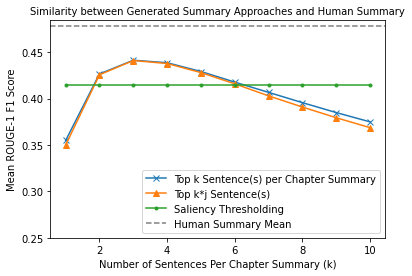

In [38]:
draw_graph(saved_results)